In [26]:
import matplotlib.pyplot as plt
from Instruments import Keithley4200
import os

import time
import pandas as pd
import plotly.express as px
import numpy as np

In [27]:
KT4200 = Keithley4200(address = "TCPIP0::10.60.5.103::1225::SOCKET")
KT4200.InstInit()

KT4200.sample = "TestFastPulse"         # Sample name
KT4200.cell = 'Test'           # Measured cell
KT4200.savepath = "Test"       # Folder name (automatically created if not existing)
KT4200.lab = 'INRiM4200'       # Lab and instrument of measurement execution
KT4200.script = 'Test_fast_pulse_v2'

Keithley4200 session opened at address TCPIP0::10.60.5.103::1225::SOCKET


[1.e-04 1.e-07 1.e-04 1.e-07 1.e-04]
0.0001, 1e-07, 0.0001, 1e-07, 0.0001
[-1 -1  1  1 -1]
-1, -1, 1, 1, -1
[-1  1  1 -1 -1]
-1, 1, 1, -1, -1
[2 2 2 2 2]
2, 2, 2, 2, 2
[0. 0. 0. 0. 0.]
0.0, 0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.0, 0.0, 0.0
0.0, 0.0, 0.0, 0.0, 0.0
Status: 1

Status: 1

Measurement Complete.
Combined DataFrame:            Voltage      Current    Timestamp        Status
0     -0.00669171   97.6599e-6            0      01020042
1     -0.00815821  100.2709e-6      7.5e-08      01020042
2     -0.00532297   99.7338e-6      1.5e-07      01020042
3      -0.0063984   99.3428e-6     2.25e-07      01020042
4     -0.00708277   99.5158e-6        3e-07      01020042
...           ...          ...          ...           ...
3996  -0.00630064   99.4520e-6    0.0002998      01020042
3997   -0.0049319   99.8793e-6  0.000299875      01020042
3998  -0.00532297   99.4245e-6   0.00029995      01020042
3999  -0.00532297   99.4064e-6  0.000300025      01020042
4000   -0.0063984   99.8431e-6    0.0003

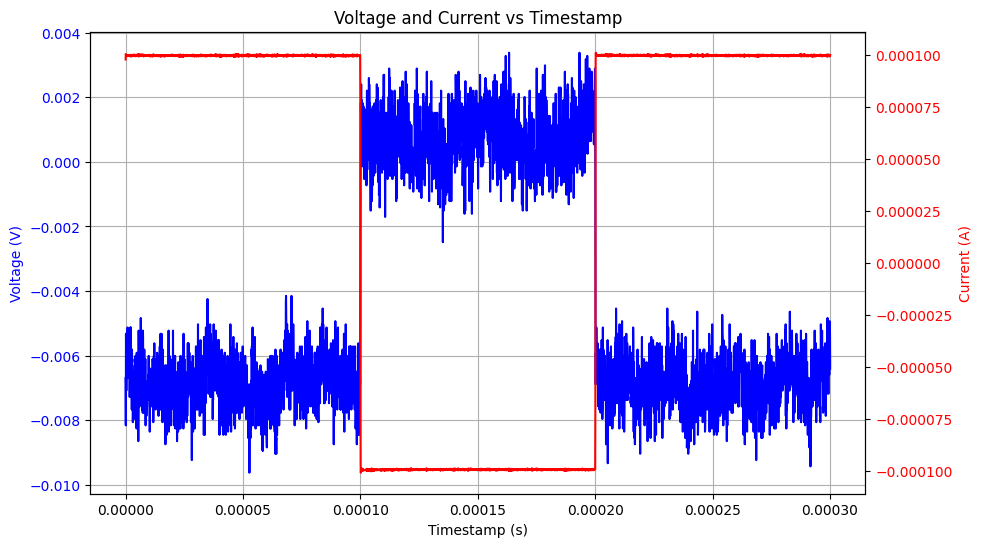

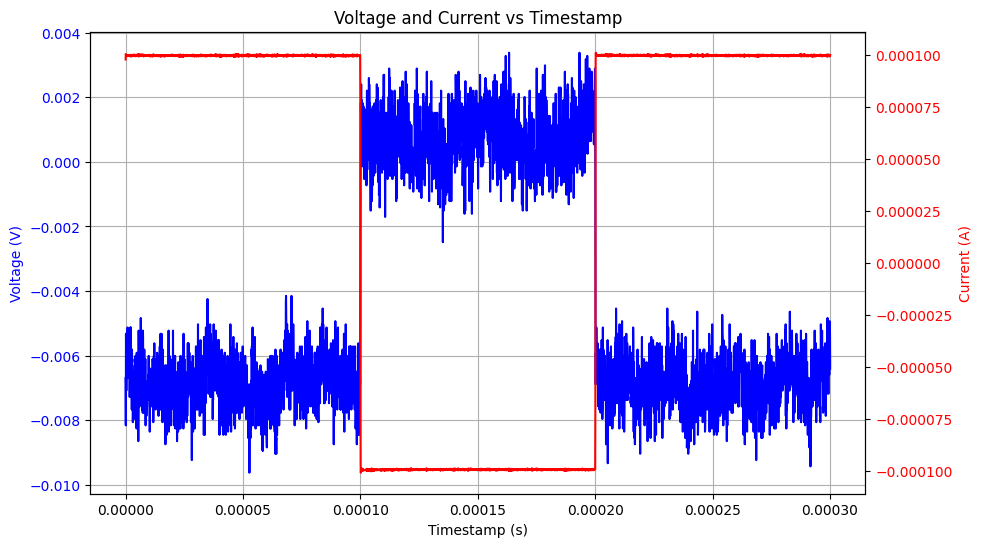

CSV file saved successfully.


In [ ]:
# Generate an array of alternated 1E-05 and 1E-07 values for a total of 82 values
seg_number = 5

""" SEGTIME_np = np.array([1E-05 if i % 2 == 0 else 1E-07 for i in range(seg_number)])
print(SEGTIME_np)
SEGTIME = ", ".join(map(str, SEGTIME_np))
print(SEGTIME) """

pulse_width = 1e-4
rising_time = 1e-7

SEGTIME_np = np.array([pulse_width if i % 2 == 0 else rising_time for i in range(seg_number)])
print(SEGTIME_np)
SEGTIME = ", ".join(map(str, SEGTIME_np))
print(SEGTIME)

STARTV_1_np = np.array([-1 if (i // 2) % 2 == 0 else 1 for i in range(seg_number)])
print(STARTV_1_np)
STARTV_1 = ", ".join(map(str, STARTV_1_np))
print(STARTV_1)


STOPV_1_np = np.roll(STARTV_1_np, -1)
print(STOPV_1_np)
STOPV_1 = ", ".join(map(str, STOPV_1_np))
print(STOPV_1)

MEASTYPE_np = np.full(seg_number, 2)
print(MEASTYPE_np)
MEASTYPE = ", ".join(map(str, MEASTYPE_np))
print(MEASTYPE)

MEASSTART_np = np.zeros(seg_number)
print(MEASSTART_np)
MEASSTART = ", ".join(map(str, MEASSTART_np))
print(MEASSTART)

MEASSTOP = SEGTIME

STARTV_2_np  = np.zeros(seg_number)
STARTV_2 = ", ".join(map(str, STARTV_2_np))
print(STARTV_2)

STOPV_2_np  = np.zeros(seg_number)
STOPV_2 = ", ".join(map(str, STOPV_2_np))
print(STOPV_2)
#Initalize the PMU and set to segARB mode
KT4200.query(":PMU:INIT 1") #0 = Pulse mode, 1 = SegArb mode

ch1 = 1
ch2 = 2
seq1 = 1

#Configure the RPM input for channel 1 of pulse card 1 to the PMU
KT4200.query(":PMU:RPM:CONFIGURE PMU1-1, 0") # 0 = PMU, 1 = CV_2W, 2 = SMU, 3 = CV_4W
#Set channel 1 for a fixed 1 mA current range
KT4200.query(f":PMU:MEASURE:RANGE {ch1}, 2, 1e-3") # set current range, 0 = Autorange, 1 = Limited Autorange (minimum range), 2 = Fixed range


KT4200.query(f":PMU:SARB:SEQ:TIME {ch1}, {seq1}, {SEGTIME}") # defines time sequence, Channel, sequence number (1 to 512), comma separated array of time segments (20 ns resolution, or 10 ns?)

KT4200.query(f":PMU:SARB:SEQ:STARTV {ch1}, {seq1}, {STARTV_1}")


KT4200.query(f":PMU:SARB:SEQ:STOPV {ch1}, {seq1}, {STOPV_1}")

KT4200.query(f":PMU:SARB:SEQ:MEAS:TYPE {ch1}, {seq1}, {MEASTYPE}") # 0 = No measurement, 1 = Spot Mean (1 sample for seg), 2 = Waveform disrete (more samples for pulse) 

KT4200.query(f":PMU:SARB:SEQ:MEAS:START {ch1}, {seq1}, {MEASSTART}") # set delay for measurement after segment start (0 for measuring all)

KT4200.query(f":PMU:SARB:SEQ:MEAS:STOP {ch1}, {seq1}, {MEASSTOP}") # set time of end measuring for each segment (set equal to SEGTIME)

#Configure the RPM input for channel 2 of pulse card 1 to the PMU
KT4200.query(":PMU:RPM:CONFIGURE PMU1-2, 0")
#Set channel 2 for a fixed 1 mA current range
KT4200.query(f":PMU:MEASURE:RANGE {ch2}, 2, 1e-3")

#Use the same segment time as sequence 1 of channel 1 for sequence 1 of channel 2
KT4200.query(f":PMU:SARB:SEQ:TIME {ch2}, {seq1}, {SEGTIME}")

KT4200.query(f":PMU:SARB:SEQ:STARTV {ch2}, {seq1}, {STARTV_2}")


KT4200.query(f":PMU:SARB:SEQ:STOPV {ch2}, {seq1}, {STOPV_2}") # set V all to 0?

#Use the same measurement types, starting, and stopping values
#as sequence 1 of channel 1 for sequence 1 of channel 2
KT4200.query(f":PMU:SARB:SEQ:MEAS:TYPE {ch2}, {seq1}, {MEASTYPE}")
KT4200.query(f":PMU:SARB:SEQ:MEAS:START {ch2}, {seq1}, {MEASSTART}")
KT4200.query(f":PMU:SARB:SEQ:MEAS:STOP {ch2}, {seq1}, {MEASSTOP}")


#Set the waveform sequence lists for channels 1 and 2
KT4200.query(f":PMU:SARB:WFM:SEQ:LIST {ch1}, {seq1}, 1") # define for each sequence how many times is in output
KT4200.query(f":PMU:SARB:WFM:SEQ:LIST {ch2}, {seq1}, 1")

#Set the output state for channels 1 and 2 to on
KT4200.query(f":PMU:OUTPUT:STATE {ch1}, 1") # set to 1 = ON before EXECUTE (turns on after execute0, set to 0 = OFF at the end of test)
KT4200.query(f":PMU:OUTPUT:STATE {ch2}, 1")

#Execute the test
KT4200.query(":PMU:EXECUTE") # performs checks and starts test execution 

#This is a loop to check the status of the test
#The :PMU:TEST:STATUS? command returns 1 if it is still running and 0 if it is idle
while True:
    status = KT4200.query(":PMU:TEST:STATUS?")
    
    #Continues loop until the test is complete
    #Casting the status string to int makes the comparison simpler since it ignores the termination characters
    if int(status) == 0:
        print("Measurement Complete.")
        break
    
    #Continously prints the status of the test every second to the terminal
    print(f"Status: {status}")
    time.sleep(1)


# Get the total number of data points
data_points_str = KT4200.query(":PMU:DATA:COUNT? 1")
data_points = int(data_points_str)

# Initialize an empty DataFrame to store all data points
df_all_channels = pd.DataFrame(columns=['Voltage', 'Current', 'Timestamp', 'Status'])

# Loop through the data points in chunks
for start_point in range(0, data_points, 2048):
    # Get data for the current chunk
    response = KT4200.query(f":PMU:DATA:GET 2, {start_point}, 2048")

    # Split the response using semicolon as the delimiter for each point
    coords = response.split(";")

    # Split into 4 separate values for each point
    coords2d = [value.split(",") for value in coords]

    # Create a DataFrame for the current chunk
    df_chunk = pd.DataFrame(coords2d, columns=['Voltage', 'Current', 'Timestamp', 'Status'])

    # Concatenate the current chunk to the overall DataFrame
    df_all_channels = pd.concat([df_all_channels, df_chunk])

#Set the output state of channels 1 and 2 to off - always turn off the output at the end of a test
KT4200.query(f":PMU:OUTPUT:STATE {ch1}, 0")
KT4200.query(f":PMU:OUTPUT:STATE {ch2}, 0")

# Reset the index of the final DataFrame
df_all_channels.reset_index(drop=True, inplace=True)

# Print the combined DataFrame
print("Combined DataFrame: ", df_all_channels)

# Convert 'Voltage', 'Current', and 'Timestamp' columns to appropriate types
df_all_channels['Voltage'] = df_all_channels['Voltage'].astype(float)
df_all_channels['Current'] = df_all_channels['Current'].astype(float)
df_all_channels['Timestamp'] = df_all_channels['Timestamp'].astype(float)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Voltage on the left y-axis
ax1.plot(df_all_channels['Timestamp'], df_all_channels['Voltage'], color='b', label='Voltage')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('Voltage (V)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for Current
ax2 = ax1.twinx()
ax2.plot(df_all_channels['Timestamp'], df_all_channels['Current'], color='r', label='Current')
ax2.set_ylabel('Current (A)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and grid
plt.title('Voltage and Current vs Timestamp')
ax1.grid()

# Show the plot
plt.show()# Convert 'Voltage', 'Current', and 'Timestamp' columns to appropriate types
df_all_channels['Voltage'] = df_all_channels['Voltage'].astype(float)
df_all_channels['Current'] = df_all_channels['Current'].astype(float)
df_all_channels['Timestamp'] = df_all_channels['Timestamp'].astype(float)

# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Voltage on the left y-axis
ax1.plot(df_all_channels['Timestamp'], df_all_channels['Voltage'], color='b', label='Voltage')
ax1.set_xlabel('Timestamp (s)')
ax1.set_ylabel('Voltage (V)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for Current
ax2 = ax1.twinx()
ax2.plot(df_all_channels['Timestamp'], df_all_channels['Current'], color='r', label='Current')
ax2.set_ylabel('Current (A)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add a title and grid
plt.title('Voltage and Current vs Timestamp')
ax1.grid()

# Show the plot
plt.show()

# Convert columns to appropriate types, floating point for the voltage and current, and a string for the timestamp and status
df_all_channels = df_all_channels.astype({'Voltage': float, 'Current': float, 'Timestamp': str, 'Status': str})

# Save DataFrame to a CSV file
df_all_channels.to_csv('data_table.csv', index=False)
print("CSV file saved successfully.")  # Verify the data was saved

# Scatter plot with Voltage High and Current High on the plot, and all data in hover
fig = px.scatter(df_all_channels, x='Timestamp', y='Voltage',
                 title='PMU SEGARB COMPLETE',
                 labels={'Timestamp': 'Time Output (s)', 'Voltage': 'Voltage (V)'},
                 hover_data=["Timestamp", "Voltage"])

# Add a line trace
fig.add_trace(px.line(df_all_channels, x='Timestamp', y='Voltage').data[0])

# Set a linear x-axis
fig.update_xaxes(type='linear')

# Show the plot
fig.show()

In [29]:
KT4200.sourceOFF()